In [15]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\Ferna\AppData\Local\Temp\ipykernel_12004\3893983819.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD )
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,RSI,RSI_Strategy,BB_SMA,STDV,Upper_Band,Lower_Band,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
8082,557.251343,566.158100,552.290983,564.219728,99326600,22.171192,1.0,590.761646,14.953190,605.714836,575.808455,0.0,1.0,0,-0.073192,0.000000
8083,552.618958,560.670897,548.742152,556.078335,88102100,19.896472,1.0,588.329672,16.974830,605.304503,571.354842,1.0,2.0,3,-0.080896,-0.024939
8084,555.551514,559.766328,550.402279,558.831907,69588200,22.915160,1.0,586.021460,18.156362,604.177822,567.865098,1.0,2.0,3,-0.076019,-0.009416
8085,548.145691,555.790031,546.416033,555.173717,74079400,23.659074,1.0,583.439880,19.702359,603.142239,563.737521,1.0,2.0,3,-0.088336,-0.049031
8086,559.468079,560.482041,548.215289,552.807851,62660300,32.929751,1.0,581.107813,19.638099,600.745912,561.469713,1.0,2.0,3,-0.069505,0.009898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8158,614.909973,616.390015,610.830017,612.880005,86258400,68.391896,-1.0,598.963626,6.973695,605.937321,591.989931,-1.0,-2.0,-3,0.022705,0.138804
8159,617.849976,619.219971,615.039978,617.380005,92502500,69.907840,0.0,600.473486,7.633655,608.107142,592.839831,-1.0,-1.0,0,0.027595,0.138804
8160,617.650024,618.830017,615.520020,616.359985,70030100,67.433913,0.0,601.807840,8.195488,610.003328,593.612352,-1.0,-1.0,0,0.027262,0.138804
8161,620.450012,620.489990,616.609985,617.239990,66510400,71.745537,0.0,603.113690,8.984510,612.098200,594.129180,-1.0,-1.0,0,0.031919,0.138804


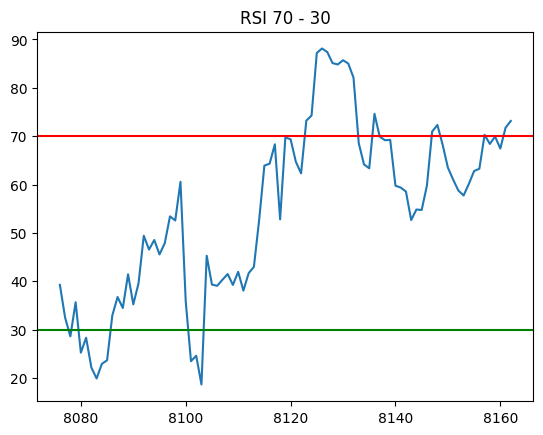

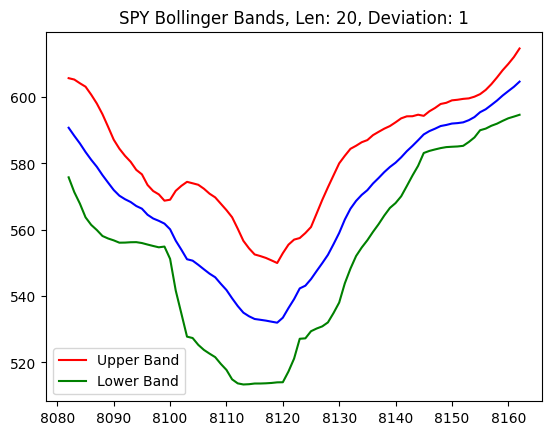

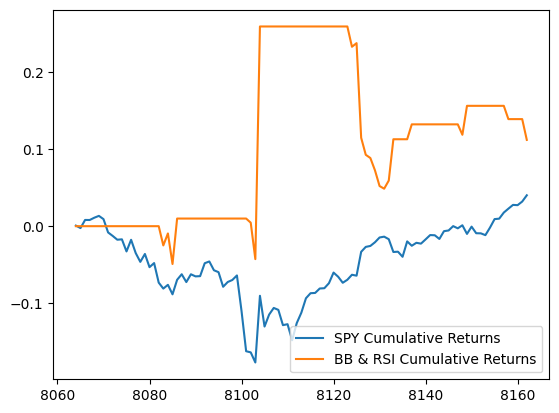

In [18]:
TICKER = 'SPY'
INTERVAL = '1d'
LEVERAGE = 3

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# BB parameters
BB_LEN = 20
DEV = 1

# RSI parameters
RSI_LENGHT = 14
RSI_OVERBOUGHT = 70 
RSI_OVERSOLD = 30

# subsection of data we are interested
LOOKBACK = 100

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD ) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

def add_RSI(df, lenght = RSI_LENGHT, overbought = RSI_OVERBOUGHT, oversold = RSI_OVERSOLD):

    price_change = df['Close'].diff() #diff() => current value - previous value

    # Separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = - price_change.where(price_change < 0, 0)

    # Average gain vs loss
    avg_gain = gain.rolling(window = lenght).mean()
    avg_loss = loss.rolling(window = lenght).mean()

    # Calculate RSI
    rs = avg_gain/avg_loss # what % of the avg loss is the avg gain
    rsi = 100 - (100/(1 + rs))

    df['RSI'] = rsi

    # plot the RSI
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color = 'red')
    plt.axhline(oversold, color = 'green') 
    plt.title(f'RSI {RSI_OVERBOUGHT} - {RSI_OVERSOLD}')

    return df

def add_RSI_strategy(df, overbought = RSI_OVERBOUGHT, oversold = RSI_OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, np.where(df['RSI'] < oversold, 1, 0))
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)

    return df

def add_bollinger_bands(df, ticker = TICKER, dev = DEV, bb_len = BB_LEN):

    # can use ema
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['STDV'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (dev * df['STDV'])
    df['Lower_Band'] = df['BB_SMA'] - (dev * df['STDV'])

    plt.figure()
    plt.plot(df['BB_SMA'], color = 'blue')
    plt.plot(df['Upper_Band'], color = 'red', label='Upper Band')
    plt.plot(df['Lower_Band'], color = 'green', label='Lower Band')
    plt.title(f'{ticker} Bollinger Bands, Len: {bb_len}, Deviation: {dev}')
    plt.legend()

    return df

def add_bb_strategy(df):

    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(df['Close'] > df['Upper_Band'], -1, np.where(df['Close'] < df['Lower_Band'], 1, 0))
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df, leverage = LEVERAGE):
    df['Full_Strategy'] = df['BB_Strategy'] + df['RSI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, leverage, np.where(df['Full_Strategy'] == -2, -leverage, 0))

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])

    plt.legend([f'{TICKER} Cumulative Returns', f'BB & RSI Cumulative Returns'])

    return df

def main():
    df = get_data()
    df = add_RSI(df)
    df = add_RSI_strategy(df)
    df = add_bollinger_bands(df)
    df = add_bb_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df.dropna()

df = main()
df

By adjusting the Bollinger Bands deviation to 1 and increasing our leverage to 3, the RSI & BB strategy starts to show promising returns. You’re encouraged to experiment with different leverage levels, time frames, or indicator combinations. Unlike previous strategies, this setup may offer the foundation of a model that could potentially outperform the market — in this case, the S&P 500.